Noemie M.-L. Eustachon - July 2023

Finnley Howald - 2024

Code to fit RL models to behavioural data

**Recommended read:**

Robert C Wilson, Anne GE Collins (2019) Ten simple rules for the computational modeling of behavioral data eLife 8:e49547

https://doi.org/10.7554/eLife.49547




**Import Statements**

In [40]:
import csv
import pandas as pd
from pathlib import Path
import re
import itertools
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import softmax, log_softmax
from scipy.optimize import minimize

In [41]:
# Set the root folder to traverse
root_folder = Path('C:/U2/Fall/COMP_396/RL_Modeling/Cohort5')  # Replace with your data folder path

# Output Excel file path
output_excel = Path('C:/U2/Fall/COMP_396/RL_Modeling/RAW_Cohort5_Compiled.xlsx')  # Replace with your desired output file path
path_to_save_data = Path('C:/U2/Fall/COMP_396/RL_Modeling/Example_Data')

# **1.0 Data Preprocesing**

## **1.1 Compile All Trial Data from Cohort 5 to one Dataframe**

In [43]:
def short_csv_to_df(file_path):
    '''
    Converts a CSV file with the same format as files ending with "(short)" and converts it to a DataFrame.
    
    Parameters:
        file_path (Path): The path of the CSV file to convert to a DataFrame.
    
    Returns:
        df (DataFrame): A DataFrame representing the important lines from the CSV file.
    '''
    csv_list = []
    column_titles = ["Block", "Tone", "ToneTime", "Unused", "Prob", "Choice", "Reward", "Latency", "Lick", "OutofTotal"]

    with open(file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        first_trial_start = False

        for index, row in enumerate(csv_reader):
            if len(row) > 1 and row[1].strip().isdigit() and int(row[1].strip()) >= 1:
                first_trial_start = True

            if first_trial_start:
                if len(row) >= len(column_titles):
                    csv_list.append(row[:len(column_titles)])
                else:
                    # Pad the row with empty strings if it's shorter than expected
                    csv_list.append(row + [''] * (len(column_titles) - len(row)))

    df = pd.DataFrame(csv_list, columns=column_titles)
    return df

def long_csv_to_df(file_path):
    '''
    Converts a CSV file with the same format as files ending with "(long)" and converts it to a DataFrame.
    
    Parameters:
        file_path (Path): The path of the CSV file to convert to a DataFrame.
    
    Returns:
        df (DataFrame): A DataFrame representing the important lines from the CSV file.
    '''
    csv_list = []
    column_titles = [
        "Trial", "Tone", "Total Licks", "Lick Side Number", "Time", "ToneTime", "Latency", "Decision",
        "Reward", "Num of No Decision", "Num of Consecutive No Decision", "Block", "Left Prob", "Right Prob"
    ]

    with open(file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        for index, row in enumerate(csv_reader):
            if index >= 3:
                if len(row) > 1 and row[1].strip():
                    # Ensure the row has the correct number of columns
                    row = row[:len(column_titles)] + [''] * (len(column_titles) - len(row))
                    csv_list.append(row)

    df = pd.DataFrame(csv_list, columns=column_titles)

    # No need to standardize 'Reward' here; it will be handled in standardize_df
    return df

def process_csv_file_short_or_long(file_path):
    '''
    Determines whether the file is "(short)" or "(long)" and processes it using the appropriate function.
    
    Parameters:
        file_path (Path or str): Path of the CSV file to process.
    
    Returns:
        DataFrame: The resulting DataFrame from either the short or long CSV processing function.
    '''
    file_path = Path(file_path)

    if "(short)" in file_path.stem:
        return short_csv_to_df(file_path)
    elif "(long)" in file_path.stem:
        return long_csv_to_df(file_path)
    else:
        return None

def standardize_df(df):
    '''
    Standardizes the DataFrame columns to a common set and standardizes the 'Reward' and 'Choice' column values.
    Maps columns from the '(long)' CSV files to match the standardized column names.
    Ensures that 'L' is added before 'Prob' values only when appropriate.
    
    Parameters:
        df (DataFrame): The original DataFrame.
    
    Returns:
        df_standardized (DataFrame): The standardized DataFrame.
    '''
    # Define the columns to keep and their standard names
    columns_mapping = {
        'tone': 'Tone',
        'reward': 'Reward',
        'latency': 'Latency',
        'tonetime': 'ToneTime',
        'prob': 'Prob',
        'choice': 'Choice',
        'decision': 'Choice',      # Map 'Decision' to 'Choice'
        'leftprob': 'Prob',        # Map 'Left Prob' to 'Prob'
        'left prob': 'Prob',       # Handle 'Left Prob' with space
    }

    # Standardize column names: strip spaces, make lowercase, remove spaces
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '')

    # Update columns_mapping keys to match the standardized column names
    columns_mapping = {k.replace(' ', '').lower(): v for k, v in columns_mapping.items()}

    # Keep track of which columns are in the DataFrame
    df_columns = set(df.columns)

    # Select and rename columns that exist in the DataFrame
    existing_columns = [col for col in df.columns if col in columns_mapping]
    df_standardized = df[existing_columns].rename(columns={col: columns_mapping[col] for col in existing_columns})

    # Standardize 'Reward' values
    if 'Reward' in df_standardized.columns:
        df_standardized['Reward'] = df_standardized['Reward'].astype(str).str.strip().str.lower()
        df_standardized['Reward'] = df_standardized['Reward'].replace({
            'rewarded': 'Y',
            'not rewarded': 'N',
            'y': 'Y',
            'n': 'N'
        })

    # Standardize 'Choice' values
    if 'Choice' in df_standardized.columns:
        df_standardized['Choice'] = df_standardized['Choice'].astype(str).str.strip().str.lower()
        df_standardized['Choice'] = df_standardized['Choice'].replace({
            'no decision': 'N',
            'decision r': 'R',
            'decision l': 'L',
            'r': 'R',
            'l': 'L',
            'n': 'N'
        })
        # Handle cases where 'Choice' might be 'Decision:L', 'Decision:R', etc.
        df_standardized['Choice'] = df_standardized['Choice'].apply(lambda x: x[-1].upper() if 'decision' in x else x.upper())

    # If 'Left Prob' was in the original columns, we know 'Prob' came from 'Left Prob'
    if 'leftprob' in df_columns or 'left prob' in df_columns:
        # Clean up the 'Prob' column and ensure values are strings
        df_standardized['Prob'] = df_standardized['Prob'].astype(str).str.strip()
        # Add 'L' before the integer in 'Prob' column if not already present and if the cell is not empty
        def add_L_prefix(x):
            if pd.notnull(x) and x != '':
                x = str(x).strip()
                if not x.startswith(('L', 'R')):
                    return 'L' + x
                else:
                    return x
            else:
                return x  # Return the value as is if empty or NaN

        df_standardized['Prob'] = df_standardized['Prob'].apply(add_L_prefix)
    else:
        # For 'Prob' values from '(short)' CSV files, ensure they are formatted correctly
        df_standardized['Prob'] = df_standardized['Prob'].astype(str).str.strip()

    return df_standardized

def process_csv_file_and_get_mouse_id(file_path):
    '''
    Processes a CSV file and returns a DataFrame with standardized columns, an added 'Date' column, and the mouse ID.
    
    Parameters:
        file_path (Path): Path to the CSV file.
    
    Returns:
        df (DataFrame): Processed DataFrame with standardized columns and added 'Date' column.
        mouse_id (str): The mouse ID extracted from the file name.
    '''
    df = process_csv_file_short_or_long(file_path)

    if df is None or df.empty:
        return None, None

    # Extract date code from the parent folder name
    folder_name = file_path.parent.name
    date_match = re.search(r'(\d{6})', folder_name)
    if date_match:
        date_code = date_match.group(1)
        # Use the date code as a string
        date_str = date_code
    else:
        # If no date code is found, set to an empty string or handle as needed
        date_str = ''

    # Extract mouse ID from the file name using regex
    file_name = file_path.stem
    match = re.search(r'(HPD\d+)', file_name.replace(' ', ''))
    if match:
        mouse_id = match.group(1)
    else:
        # Handle cases where 'HPD' is not found
        mouse_id = None

    # Standardize DataFrame
    df = standardize_df(df)

    # Add 'MouseID' column
    df['MouseID'] = mouse_id

    # Add 'Date' column as the last column
    df['Date'] = date_str
    # Reorder columns to ensure 'Date' is the last column
    columns_order = [col for col in df.columns if col != 'Date'] + ['Date']
    df = df[columns_order]

    return df, mouse_id

def traverse_and_collect_data(folder_path):
    '''
    Traverses folders and collects data per mouse.
    
    Parameters:
        folder_path (Path): Path to the root folder.
    
    Returns:
        mouse_data (dict): Dictionary with mouse IDs as keys and lists of DataFrames as values.
    '''
    folder = Path(folder_path)
    mouse_data = {}

    def dfs_recursive(folder):
        for item in folder.iterdir():
            if item.is_file() and item.suffix == '.csv':
                df, mouse_id = process_csv_file_and_get_mouse_id(item)

                if df is not None and mouse_id is not None:
                    if mouse_id not in mouse_data:
                        mouse_data[mouse_id] = []
                    mouse_data[mouse_id].append(df)
            elif item.is_dir():
                dfs_recursive(item)

    dfs_recursive(folder)
    return mouse_data

def write_mouse_data_to_excel(mouse_data, output_path):
    '''
    Writes mouse data to an Excel file, each sheet representing a mouse.
    
    Parameters:
        mouse_data (dict): Dictionary with mouse IDs as keys and lists of DataFrames as values.
        output_path (str or Path): Path to the output Excel file.
    '''
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for mouse_id, df_list in mouse_data.items():
            combined_df = pd.concat(df_list, ignore_index=True)
            sheet_name = mouse_id[:31]  # Excel sheet names have a maximum length of 31 characters

            combined_df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Written data for mouse {mouse_id} to sheet '{sheet_name}'")

In [44]:
# Traverse folders and collect data
mouse_data = traverse_and_collect_data(root_folder)

# Write data to Excel
write_mouse_data_to_excel(mouse_data, output_excel)

print("All data has been written to", output_excel)

Written data for mouse HPD14 to sheet 'HPD14'
Written data for mouse HPD15 to sheet 'HPD15'
Written data for mouse HPD17 to sheet 'HPD17'
Written data for mouse HPD18 to sheet 'HPD18'
Written data for mouse HPD19 to sheet 'HPD19'
Written data for mouse HPD20 to sheet 'HPD20'
Written data for mouse HPD21 to sheet 'HPD21'
Written data for mouse HPD22 to sheet 'HPD22'
Written data for mouse HPD23 to sheet 'HPD23'
All data has been written to C:\U2\Fall\COMP_396\RL_Modeling\RAW_Cohort5_Compiled.xlsx


In [54]:
print(mouse_data)
# print(mouse_data['HPD14'])
# for mouse_id in mouse_data.keys():
#     print(mouse_id)

'''
General Structure of mouse_data
{
    'HPD15': [
        DataFrame from 240910_HPD15_data.csv,
        DataFrame from 240911_HPD15_data.csv,
        ...
    ],
    'HPD16': [
        DataFrame from 240910_HPD16_data.csv,
        ...
    ],
    ...
}
'''

{'HPD14': [   Tone ToneTime  Latency Choice Reward  Prob MouseID    Date
0     1        0               N         L100   HPD14  240916
1     2        0               N         L100   HPD14  240916
2     3             40501      R      N  L100   HPD14  240916
3     4             55501      R      N  L100   HPD14  240916
4     5        0               N         L100   HPD14  240916
..  ...      ...      ...    ...    ...   ...     ...     ...
61   62        0               N         L100   HPD14  240916
62   63            908502      R      N  L100   HPD14  240916
63   64            921501      R      N  L100   HPD14  240916
64   65        0               N         L100   HPD14  240916
65   66        0               N         L100   HPD14  240916

[66 rows x 8 columns],      Tone  ToneTime  Prob Choice Reward Latency MouseID    Date
0       2     21009  L100      N      N           HPD14  240917
1       3     28009  L100      N      N           HPD14  240917
2       4     34009  L100    

"\nGeneral Structure of mouse_data\n{\n    'HPD15': [\n        DataFrame from 240910_HPD15_data.csv,\n        DataFrame from 240911_HPD15_data.csv,\n        ...\n    ],\n    'HPD16': [\n        DataFrame from 240910_HPD16_data.csv,\n        ...\n    ],\n    ...\n}\n"

## **1.2 Process The Compiled File**

**Creates the Data Dataframe**

In [ ]:

processed_data = {}  # Initialize a dictionary to store processed DataFrames

# Process each mouse in mouse_data
for mouse_id, df_list in mouse_data.items():
    if mouse_id != 'HPD14':
        break
    
    
    # Combine the list of DataFrames (for each session for mouse_id) into one DataFrame
    

    df = pd.concat(df_list, ignore_index=True)

    # # Check if the DataFrame has at least 1000 rows
    # if df.shape[0] < 1000:  # df.shape[0] gives the number of rows
    #     print(f"Skipping mouse '{mouse_id}' due to insufficient rows ({df.shape[0]}).")
    #     continue

    # Standardize column names
    df.columns = df.columns.str.strip().str.lower()  # Strip spaces and make lowercase


    # Check if necessary columns exist in the input data
    required_columns = ["tone", "prob", "reward"]
    if not all(col in df.columns for col in required_columns):
        print(f"Skipping mouse '{mouse_id}' due to missing columns.")
        continue

    # print(df)

    # Remove rows where 'tone' is empty or contains invalid values
    df["tone"] = df["tone"].astype(str).str.strip()  # Strip spaces
    df["tone"] = pd.to_numeric(df["tone"], errors="coerce")  # Convert to numeric, set invalid values to NaN
    df = df.dropna(subset=["tone"])  # Drop rows where 'tone' is NaN
    df["tone"] = df["tone"].astype(int)  # Safely convert to integers

    # Strip spaces from 'prob' and 'reward' column values
    df["prob"] = df["prob"].astype(str).str.strip()
    df["reward"] = df["reward"].astype(str).str.strip()

    # print(df)

    # Initialize the processed DataFrame
    data = pd.DataFrame()

    print(data)

    # Map 'Choice' values to 'Left' and 'Left Prob'
    def map_left(choice_value):
        if choice_value == 'L':
            return 1
        elif choice_value == 'R':
            return 0
        else:
            return None
        

    def map_left_prob(prob_value):
        # Map 'Prob' to numerical left probability
        if prob_value.startswith('L'):
            try:
                prob_num = int(prob_value[1:])
                return prob_num / 100.0
            except:
                return None
        elif prob_value.startswith('R'):
            try:
                prob_num = int(prob_value[1:])
                return 1 - (prob_num / 100.0)
            except:
                return None
        else:
            return None

    def map_reward(reward_value):
        reward_value = reward_value.lower()
        if reward_value in ["y", "rewarded", "yes"]:
            return 1
        elif reward_value in ["n", "not rewarded", "no"]:
            return 0
        else:
            return None

    # Create 'Left' column based on 'Prob'
    data["Left"] = df["choice"].apply(map_left)
    
    # Set 'Left Prob' column
    data["Left Prob"] = df["prob"].apply(map_left_prob)

    # Map 'Reward' values
    data["Reward"] = df["reward"].apply(map_reward)
    
    print(data)    


    # Map 'Reward' values
    processed_df["Reward"] = df["reward"].apply(map_reward)

    # Set 'Left Prob' column
    processed_df["Left Prob"] = df["prob"].apply(map_left_prob)

    # Remove rows where 'Left', 'Reward', or 'Left Prob' is None after mapping
    
    processed_df = processed_df[processed_df["Reward"].notna()]
    

    # Clean and preprocess 'Left' and 'Reward' columns
    processed_df["Left"] = pd.to_numeric(processed_df["Left"], errors='coerce').dropna().astype(int)
    processed_df["Reward"] = pd.to_numeric(processed_df["Reward"], errors='coerce').dropna().astype(int)

    # Add 'Session' column from the 'Date' column in the data
    if 'date' in df.columns:
        processed_df["Session"] = df['date']
    else:
        processed_df["Session"] = ''  # Or use another default value

    # Set 'Trial' column to match the 'Tone' column
    processed_df["Trial"] = df["tone"]

    # Store the processed DataFrame in the dictionary
    processed_data[mouse_id] = processed_df



Empty DataFrame
Columns: []
Index: []
       Left  Left Prob  Reward
0       NaN        1.0     NaN
1       NaN        1.0     NaN
2       0.0        1.0     0.0
3       0.0        1.0     0.0
4       NaN        1.0     NaN
...     ...        ...     ...
10743   0.0        0.0     1.0
10744   0.0        0.0     1.0
10745   0.0        0.0     1.0
10746   NaN        0.0     NaN
10747   0.0        0.0     1.0

[2014 rows x 3 columns]


In [60]:
def process_mouse_data(mouse_data):
    """
    Processes the mouse_data dictionary into a standardized format.
    Removes mice with fewer than 1000 rows.
    Returns a dictionary of processed DataFrames per mouse.

    Parameters:
        mouse_data (dict): Dictionary with mouse IDs as keys and lists of DataFrames as values.

    Returns:
        processed_data (dict): Dictionary with mouse IDs as keys and processed DataFrames as values.
    """
    processed_data = {}  # Initialize a dictionary to store processed DataFrames

    # Process each mouse in mouse_data
    for mouse_id, df_list in mouse_data.items():
        # Combine the list of DataFrames (for each session for mouse_id) into one DataFrame

        df = pd.concat(df_list, ignore_index=True)

        # # Check if the DataFrame has at least 1000 rows
        # if df.shape[0] < 1000:  # df.shape[0] gives the number of rows
        #     print(f"Skipping mouse '{mouse_id}' due to insufficient rows ({df.shape[0]}).")
        #     continue

        # Standardize column names
        df.columns = df.columns.str.strip().str.lower()  # Strip spaces and make lowercase


        # Check if necessary columns exist in the input data
        required_columns = ["tone", "prob", "reward"]
        if not all(col in df.columns for col in required_columns):
            print(f"Skipping mouse '{mouse_id}' due to missing columns.")
            continue

        # Remove rows where 'tone' is empty or contains invalid values
        df["tone"] = df["tone"].astype(str).str.strip()  # Strip spaces
        df["tone"] = pd.to_numeric(df["tone"], errors="coerce")  # Convert to numeric, set invalid values to NaN
        df = df.dropna(subset=["tone"])  # Drop rows where 'tone' is NaN
        df["tone"] = df["tone"].astype(int)  # Safely convert to integers

        # Strip spaces from 'prob' and 'reward' column values
        df["prob"] = df["prob"].astype(str).str.strip()
        df["reward"] = df["reward"].astype(str).str.strip()

        # Initialize the processed DataFrame
        processed_df = pd.DataFrame()

        # Map 'Choice' values to 'Left' and 'Left Prob'
        def map_left(choice_value):
            if choice_value == 'L':
                return 1
            elif choice_value == 'R':
                return 0
            else:
                return None

        def map_left_prob(prob_value):
            # Map 'Prob' to numerical left probability
            if prob_value.startswith('L'):
                try:
                    prob_num = int(prob_value[1:])
                    return prob_num / 100.0
                except:
                    return None
            elif prob_value.startswith('R'):
                try:
                    prob_num = int(prob_value[1:])
                    return 1 - (prob_num / 100.0)
                except:
                    return None
            else:
                return None

        def map_reward(reward_value):
            reward_value = reward_value.lower()
            if reward_value in ["y", "rewarded", "yes"]:
                return 1
            elif reward_value in ["n", "not rewarded", "no"]:
                return 0
            else:
                return None

        # Create 'Left' column based on 'Prob'
        processed_df["Left"] = df["choice"].apply(map_left)

        # Map 'Reward' values
        processed_df["Reward"] = df["reward"].apply(map_reward)

        # Set 'Left Prob' column
        processed_df["Left Prob"] = df["prob"].apply(map_left_prob)

        # Remove rows where 'Left', 'Reward', or 'Left Prob' is None after mapping
        processed_df = processed_df[processed_df["Left"].notna()]
        processed_df = processed_df[processed_df["Reward"].notna()]
        processed_df = processed_df[processed_df["Left Prob"].notna()]

        # Clean and preprocess 'Left' and 'Reward' columns
        processed_df["Left"] = pd.to_numeric(processed_df["Left"], errors='coerce').dropna().astype(int)
        processed_df["Reward"] = pd.to_numeric(processed_df["Reward"], errors='coerce').dropna().astype(int)

        # Add 'Session' column from the 'Date' column in the data
        if 'date' in df.columns:
            processed_df["Session"] = df['date']
        else:
            processed_df["Session"] = ''  # Or use another default value

        # Set 'Trial' column to match the 'Tone' column
        processed_df["Trial"] = df["tone"]

        # Store the processed DataFrame in the dictionary
        processed_data[mouse_id] = processed_df

    return processed_data



def write_processed_data_to_excel(processed_data, output_file):
    """
    Writes the processed data to an Excel file.

    Parameters:
        processed_data (dict): Dictionary with mouse IDs as keys and processed DataFrames as values.
        output_file (str): Path to the output Excel file.
    """
    with pd.ExcelWriter(output_file, engine="openpyxl", mode="w") as writer:
        for mouse_id, processed_df in processed_data.items():
            # Write the processed data to the output file in the corresponding sheet
            sheet_name = mouse_id[:31]  # Excel sheet names have a maximum length of 31 characters
            processed_df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Processed mouse: {mouse_id}")

    print(f"Output written to: {output_file}")


In [61]:
# Example usage:

# Assuming 'mouse_data' is already defined from your previous code
# Output Excel file path
output_excel = r"C:\U2\Fall\COMP_396/RL_Modeling\Processed_Cohort5_Data.xlsx"  # Replace with your desired output file path

# Run the function
data = process_mouse_data(mouse_data)
write_processed_data_to_excel(data, output_excel)

Processed mouse: HPD14
Processed mouse: HPD15
Processed mouse: HPD17
Processed mouse: HPD18
Processed mouse: HPD19
Processed mouse: HPD20
Processed mouse: HPD21
Processed mouse: HPD22
Processed mouse: HPD23
Output written to: C:\U2\Fall\COMP_396/RL_Modeling\Processed_Cohort5_Data.xlsx


**Creates the Mouse Info Dataframe**

In [8]:
# implement this later not sure if needed rn

def create_mouse_id_dataframe(mouse_data):
    """
    Creates a DataFrame with only the mouse IDs.

    Parameters:
        mouse_data (dict): Dictionary with mouse IDs as keys and lists of DataFrames as values.

    Returns:
        mouse_id_df (pd.DataFrame): DataFrame with a single column containing the mouse IDs.
    """
    # Extract mouse IDs from the keys of the mouse_data dictionary
    mouse_ids = list(mouse_data.keys())

    # Create a DataFrame with a single column for mouse IDs
    mouse_id_df = pd.DataFrame({"ID": mouse_ids})

    return mouse_id_df

In [9]:
Mouse_Info = create_mouse_id_dataframe(data)

In [10]:
print(data['HPD14'])

       Left  Reward  Left Prob Session  Trial
2         1       0        1.0  240916      3
3         1       0        1.0  240916      4
5         1       0        1.0  240916      6
6         1       0        1.0  240916      7
8         1       0        1.0  240916      9
...     ...     ...        ...     ...    ...
10742     1       1        0.0  241003    121
10743     1       1        0.0  241003    122
10744     1       1        0.0  241003    123
10745     1       1        0.0  241003    124
10747     1       1        0.0  241003    126

[1767 rows x 5 columns]


In [11]:
print(Mouse_Info)

      ID
0  HPD14
1  HPD15
2  HPD17
3  HPD18
4  HPD19
5  HPD20
6  HPD21
7  HPD22
8  HPD23


# **2.0 RL Models**

**This section implements 10 different RL models.** Below is a table summarising the number of parameters per models and what they correspond to.


Model Name| Abbreviation | # Param| Parameters
--------  |--------------|------- |-----------
Random                                        | Random| 1|b = tendency to press left
Win-Stay/Loose-Shift                          | WSLS|1|$\varepsilon$ = tendency of win-stay/loose-shift
Q-learning                                    |Q|2|$\alpha$ = learning rate $\beta$ = exploration rate
Double Q-learning                             |DQ|3|$\alpha^+$ = learning rate for rewarded trials $\alpha^-$ = learning rate for non rewarded trials $\beta$ = exploration rate
Q learning with choice kernel                 |QCK|4|$\alpha$ = learning rate $\alpha_c$ = learning rate for choice kernel $\beta$ = exploration rate $\beta_c$ = exploration rate for choice kernel
Double Q-learning with choice kernel          |DQCK|5| $\alpha^+$ = learning rate for rewarded trials $\alpha^-$ = learning rate for non rewarded trial $\alpha_c$ = learning rate for choice kernel $\beta$ = exploration rate $\beta_c$ = exploration rate for choice kernel
Q-learning wih choice kernel balanced         |QCKe|5|$\alpha$ = learning rate $\alpha_c$ = learning rate for choice kernel $\beta$ = exploration rate $\beta_c$ = exploration rate for choice kernel $\eta$ = tendency to rely on reward history rather than action history
Double Q-learning with choice kernel balanced |DQCKe| 6 | $\alpha^+$ = learning rate for rewarded trials $\alpha^-$ = learning rate for non rewarded trials $\alpha_c$ = learning rate for choice kernel $\beta$ = exploration rate $\beta_c$ = exploration rate for choice kernel $\eta$ = tendency to rely on reward history rather than action history
Q-learning with forgetting                    |QF|3| $\alpha$ = learning rate $\alpha_f$ = forgetting rate $\beta$ = exploration rate
Double Q-learning with forgetting             |DQF| 4| $\alpha^+$ = learning rate for rewarded trials $\alpha^-$ = learning rate for non rewarded trial $\beta$ = exploration rate

In [12]:
parameter_dict = {'Random': ['b'], 'WSLS': ['ε'], 'Q':['α', 'β'],
              'DQ': ['α+', 'α-', 'β'], 'QCK': ['α', 'β', 'αc', 'β_c'],
              'DQCK': ['α+', 'α-', 'β', 'α_c', 'β_c'],
              'QCKe': ['α', 'β', 'α_c', 'β_c', 'η'],
              'DQCKe': ['α+', 'α-', 'β', 'α_c', 'β_c', 'η'],
              'QF': ['α', 'α_f', 'β'], 'DQF': ['α+', 'α-','α_f','β'], 'DQFCK':  ['α+', 'α-','α_f','β', 'αc', 'β_c']}

## **2.1 Non-RL Models**

**Random Model**

Actions are chosen randomly with a side bias $b$. The probability of choosing lever $L$ at triat $t$ is:

\begin{align}
p_t^L = b
\end{align}


In [13]:
def Random(parameters, actions, rewards, plots=False):
  b = parameters[0] #side bias
  Q = np.array([0.5, 0.5]) #Q-values, initialised at 0.5
  log_action_prob_trials =np.zeros(len(rewards)) #log probability of choosing action a at ach trial
  generated_actions = np.zeros(len(rewards))
  for t, (a,r) in enumerate(zip(actions, rewards)):
    action_prob = [1-b, b] #choose right with 1-b chance, and left with b chance
    log_action_prob_trials[t] = np.log(action_prob[a]) #save log probability of choosing the mouse action a
    generated_actions[t] = np.random.choice([0,1],p= action_prob)
  if not plots:
    return -np.sum(log_action_prob_trials)
  else:
    return generated_actions

**Win-Stay/Loose-Shift model (WSLS)**

Actions are chosen based on win-stay/loose-shift with $1- \varepsilon/2$ chance and win-shift loose-stay with $\varepsilon/2$ chance. The probability of choosing lever $L$ at trial $t$ is:


\begin{align}
        \ p_t^L = \left\{
        \begin{array}{cl}
        1- \varepsilon/2  & if & Win-Stay/Loose-Shift \\
        \varepsilon/2 & if &Win-Shift/Loose-stay
        \end{array}
        \right.
    \end{align}

In [14]:
def WSLS(parameters, actions, rewards, plots=False):
  epsilon = parameters[0] #epsilon
  Q = np.array([0.5, 0.5]) #Q-values, initialised at 0.5
  log_action_prob_trials =np.zeros(len(rewards)) #log probability of choosing action a at ach trial
  previous_a = actions[0]
  previous_r = rewards[0]
  generated_actions = np.zeros(len(rewards))
  for t, (a,r) in enumerate(zip(actions[1:], rewards[1:])):

    stay = previous_a==a

    #win-stay/loose-shift
    if stay == previous_r:
      action_prob= 1-(epsilon/2) #1-epsilon/2 prob of choosing the lever chosen by the mouse

    #win-shift/loose-stay
    else:
      action_prob= epsilon/2 #epsilon/2 prob of choosing the lever chosen by the mouse

    log_action_prob_trials[t] = np.log(action_prob) #save log probability of choosing the mouse action a
    previous_a = a
    previous_r = r



  return -np.sum(log_action_prob_trials)

## **2.2 Q-Learning Models**

**Q-Learning model (Q)**

Actions are chosen based on a standard Q-learning algorithm with one learning rate $\alpha$ and inverse temperate $\beta$. For each trial $t$, the Q-value of option $L$, $Q_{t+1}^L$, is updated as follow:

\begin{align}
Q_{t+1}^L = Q_t^L + \alpha (r_t - Q_t^L)
    \end{align}

with $r_t$ the reward (0 or 1) earned at trial $t$. Actions are then chosen by on the softmax exploration with parameter $\beta$. The probability of chosing option $L$ is as follows:

\begin{align}
p(a_{t+1} =L) = \frac{e^{\beta Q_t^L}}{\sum{e^{\beta Q_t^l}}}
\end{align}



In [15]:
def Q(parameters,*args, plots=False):
  alpha, beta = parameters
  actions, rewards = args
  #1. Initialise variables
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t

  #2. Compute Q values at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta, axis=1)
    return action_prob


**Double Q-learning  model (DQ)**

Actions are chosen based on a Q-learning algorithm with two learning rate for positive and negative rewards, $\alpha^+$ and $\alpha^-$, and inverse temperate $\beta$. For each trial $t$, the Q-value of option $L$, $Q_{t+1}^L$, is updated as follow:


\begin{align}
        \ Q_{t+1}^L = \left\{
        \begin{array}{cl}
         Q_t^L + \alpha^+(r_t - Q_t^L)  & r=1 \\
         Q_t^L + \alpha^-(r_t - Q_t^L)  & r=0
        \end{array}
        \right.
    \end{align}

with $r_t$ the reward (0 or 1) earned at trial $t$. Actions are then chosen by on the softmax exploration with parameter $\beta$. The probability of chosing option $L$ is as follows:

\begin{align}
p(a_{t+1} =L) = \frac{e^{\beta Q_t^L}}{\sum{e^{\beta Q_t^l}}}
\end{align}

In [16]:
def DQ(parameters, actions, rewards,plots=False):
  alpha_pos, alpha_neg, beta = parameters

  #1. Initialise variables
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t
  alpha = np.ones( (len(rewards),2)) #matrix with alppha_pos in column 1 and alpha_neg in columns 2
  alpha[:,0 ] =alpha[:,0 ] * alpha_neg
  alpha[:,1 ] =alpha[:,1 ] * alpha_pos
  alpha = alpha[np.arange(len(alpha)), rewards] #vector withe learning rate to use at each trial t (alpah_neg if r=0, alpha_pos if r=1)

  #2. Compute Q values at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha[t] * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta, axis=1)
    return action_prob

## **2.3 Choice Kernel Models**

**Q learning+ Choice Kernel (QCK)**


This model computes a value updating function $Q$ and a choice kernel function $CK$ indepently. At each trial $t$, the Q-value of chosen lever $L$ is updated as follows:

\begin{align}
Q_{t+1}^L = Q_t^L + \alpha (r_t - Q_t^L)
    \end{align}

with $r_t$ the reward (0 or 1) earned at trial $t$. The choice kernel $CK$ of lever $L$ is then computed, and represents the tendency of a mouse to repeat the same action. It is updated as follows:

\begin{align}
CK_{t+1}^L = CK_{t}^L + \alpha_c (a_t^L -  CK_{t}^L )
    \end{align}

with $a_t^L$ a binary variable indicating whether the lever $L$ was chosen on trial $t$. If $a_t^L$=0, then $CK_{t+1}^L$ decreases, making it less likely that the mouse will choose lever $L$ at the next trial. The probability of choosing the lever $L$ is computed based on a linear combination of the $Q$ value and the choice kernel $CK$:

\begin{align}
p_t^L = \frac{e^{\beta Q_t^L +\beta_c CK_{t}^L }}{\sum{e^{\beta Q_t^l + \beta_c CK_{t}^l}}}
    \end{align}

The model has 4 parameters: learning rate for value updating \alpha, learning rate for the choice kernel updating \alpha_c, the inverse temperate for value updating \beta and for the choice kernel $\beta_c.$


In [17]:
def QCK(parameters, actions, rewards, plots=False):
  alpha, beta, alpha_c, beta_c = parameters

  #1. Initialise variables
  CK = np.zeros( (len(rewards),2)) #choice kernel values initialised as [0, 0]
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t

  #2. Compute Q values at CK at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same
      CK[t+1, a] = CK[t, a] + alpha_c*(1-CK[t, a] )
      CK[t+1, 1- a] = CK[t, 1- a] + alpha_c*(-CK[t, a] )

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta + CK*beta_c, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta + CK*beta_c, axis=1)
    return action_prob
    return generated_actions, best_estimated_action, generated_probabilities

**double Q-learning + choice kernel (DQCK)**

This model computes a value updating function $Q$ and a choice kernel function $CK$ indepently. At each trial $t$, the Q-value of chosen lever $L$ is updated as follows:

\begin{align}
        \ Q_{t+1}^L = \left\{
        \begin{array}{cl}
         Q_t^L + \alpha^+(r_t - Q_t^L)  & r=1 \\
         Q_t^L + \alpha^-(r_t - Q_t^L)  & r=0
        \end{array}
        \right.
    \end{align}

with $r_t$ the reward (0 or 1) earned at trial $t$. The choice kernel $CK$ of lever $L$ is then computed, and represents the tendency of a mouse to repeat the same action. It is updated as follows:

\begin{align}
CK_{t+1}^L = CK_{t}^L + \alpha_c (a_t^L -  CK_{t}^L )
    \end{align}

with $a_t^L$ a binary variable indicating whether the lever $L$ was chosen on trial $t$. If $a_t^L$=0, then $CK_{t+1}^L$ decreases, making it less likely that the mouse will choose lever $L$ at the next trial. The probability of choosing the lever $L$ is computed based on a linear combination of the $Q$ value and the choice kernel $CK$:

\begin{align}
p_t^L = \frac{e^{\beta Q_t^L +\beta_c CK_{t}^L }}{\sum{e^{\beta Q_t^l + \beta_c CK_{t}^l}}}
    \end{align}

The model has 4 parameters: learning rate for value updating \alpha, learning rate for the choice kernel updating $\alpha_c$, the inverse temperate for value updating \beta and for the choice kernel $\beta_c.$




In [18]:
def DQCK(parameters, actions, rewards, plots=False):
  alpha_pos, alpha_neg, beta, alpha_c, beta_c = parameters

  #1. Initialise variables
  CK = np.zeros( (len(rewards),2)) #choice kernel values initialised as [0, 0]
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t
  alpha = np.ones( (len(rewards),2)) #matrix with alppha_pos in column 1 and alpha_neg in columns 2
  alpha[:,0 ] =alpha[:,0 ] * alpha_neg
  alpha[:,1 ] =alpha[:,1 ] * alpha_pos
  alpha = alpha[np.arange(len(alpha)), rewards] #vector withe learning rate to use at each trial t (alpah_neg if r=0, alpha_pos if r=1)

  #2. Compute Q values at CK at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha[t] * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same
      CK[t+1, a] = CK[t, a] + alpha_c*(1-CK[t, a] )
      CK[t+1, 1- a] = CK[t, 1- a] + alpha_c*(-CK[t, a] )

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta + CK*beta_c, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta + CK*beta_c, axis=1)
    return action_prob

**Q-learning and choice kernel balanced (QCKe)**

This model is similar to the previous ones and computes a value updating function $Q$ and a choice kernel function $CK$ indepently.It adds a parameter $\eta$  that tunes the balance between the value updating rule and the choice kernel updating rule. This allows animals to depend their choices more heavily on values or on choice preference. At each trial $t$, the Q-value of chosen lever $L$ is updated as follows:

\begin{align}
        Q_{t+1}^L = Q_t^L + \alpha (r_t - Q_t^L)
    \end{align}


with $r_t$ the reward (0 or 1) earned at trial $t$. The choice kernel $CK$ of lever $L$ is then computed, and represents the tendency of a mouse to repeat the same action. It is updated as follows:

\begin{align}
CK_{t+1}^L = CK_{t}^L + \alpha_c (a_t^L -  CK_{t}^L )
    \end{align}

with $a_t^L$ a binary variable indicating whether the lever $L$ was chosen on trial $t$. If $a_t^L$=0, then $CK_{t+1}^L$ decreases, making it less likely that the mouse will choose lever $L$ at the next trial. The probability of choosing the lever $L$ is computed based on a linear combination of the $Q$ value and the choice kernel $CK$:

\begin{align}
p_t^L = \frac{e^{\eta \beta Q_t^L +(1-\eta)\beta_c CK_{t}^L }}{\sum{e^{\eta\beta Q_t^l + (1-\eta)\beta_c CK_{t}^l}}}
    \end{align}

The model has 4 parameters: learning rate for value updating $\alpha$, learning rate for the choice kernel updating $\alpha_c$, the inverse temperate for value updating $\beta$ and for the choice kernel $\beta_c.$


In [19]:
def QCKe(parameters, actions, rewards, plots=False):
  alpha, beta, alpha_c, beta_c, eta = parameters
  #1. Initialise variables
  CK = np.zeros( (len(rewards),2)) #choice kernel values initialised as [0, 0]
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t

  #2. Compute Q values at CK at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same
      CK[t+1, a] = CK[t, a] + alpha_c*(1-CK[t, a] )
      CK[t+1, 1- a] = CK[t, 1- a] + alpha_c*(-CK[t, a] )

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(eta*Q*beta + (1-eta)*CK*beta_c, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(eta*Q*beta + (1-eta)*CK*beta_c, axis=1)
    return action_prob

**double Qlearning and choice kernel balanced (DQCKe)**

Same but with two learning rates for positive and negative outcomes.

In [20]:
def DQCKe(parameters, actions, rewards, plots=False):
  alpha_pos, alpha_neg, beta, alpha_c, beta_c, eta = parameters

   #1. Initialise variables
  CK = np.zeros( (len(rewards),2)) #choice kernel values initialised as [0, 0]
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t
  alpha = np.ones( (len(rewards),2)) #matrix with alppha_pos in column 1 and alpha_neg in columns 2
  alpha[:,0 ] =alpha[:,0 ] * alpha_neg
  alpha[:,1 ] =alpha[:,1 ] * alpha_pos
  alpha = alpha[np.arange(len(alpha)), rewards] #vector withe learning rate to use at each trial t (alpah_neg if r=0, alpha_pos if r=1)

  #2. Compute Q values at CK at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha[t] * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] #Q value of action non chosen stays the same
      CK[t+1, a] = CK[t, a] + alpha_c*(1-CK[t, a] )
      CK[t+1, 1- a] = CK[t, 1- a] + alpha_c*(-CK[t, a] )

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(eta*Q*beta + (1-eta)*CK*beta_c, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(eta*Q*beta + (1-eta)*CK*beta_c, axis=1)
    return action_prob

## **2.4 Forgetting Models**

**Q-learning with forgetting** (Ito & Doya, 2009)

This model assumes that if a lever is not chosen at trial $t$, the mouse will 'forget' the value of that lever, and the Q-value slowly decreases with learning rate $\alpha^f$. This is equivalent to standard Q-learning if $\alpha^f=0$ (no forgetting). At each trial $t$, the Q-value of lever $L$ is updated as follows:

\begin{align}
        \ Q_{t+1}^L = \left\{
        \begin{array}{cl}
         Q_t^L + \alpha(r_t - Q_t^L)  & if & a_{t}=L\\
         Q_t^L + \alpha^f(- Q_t^L)  & if & a_{t}\neq L \\
        \end{array}
        \right.
    \end{align}

with $a_t$ boolean variable indicating whether the lever $L$ was chosen during trial $t$.

In [21]:
def QF(parameters, actions, rewards, plots=False):
  alpha, alpha_f, beta = parameters

  #1. Initialise variables
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t

  #2. Compute Q values at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] - alpha_f*Q[t, 1 - a] #Q value of action non chosen decreases over time

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta, axis=1)
    return action_prob


**double Q-learning with forgetting** (Ito & Doya, 2009)

Same as Q-learning with forgetting, but with assymetric learning rates for reinforced & non reinforced trials.

\begin{align}
        \ Q_{t+1}^L = \left\{
        \begin{array}{cl}
         Q_t^L + \alpha^+(r_t - Q_t^L)  & if & a_{t}=L, r=1\\
         Q_t^L + \alpha^-(r_t - Q_t^L)  & if & a_{t}=L, r=0\\
         Q_t^L + \alpha^f(- Q_t^L)  & if & a_{t}\neq L \\
        \end{array}
        \right.
    \end{align}

with $a_t$ boolean variable indicating whether the lever $L$ was chosen during trial $t$.

In [22]:
def DQF(parameters, actions, rewards, plots=False):
  alpha_pos, alpha_neg, alpha_f, beta = parameters

  #1. Initialise variables
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t
  alpha = np.ones( (len(rewards),2)) #matrix with alppha_pos in column 1 and alpha_neg in columns 2
  alpha[:,0 ] =alpha[:,0 ] * alpha_neg
  alpha[:,1 ] =alpha[:,1 ] * alpha_pos
  alpha = alpha[np.arange(len(alpha)), rewards] #vector withe learning rate to use at each trial t (alpah_neg if r=0, alpha_pos if r=1)

  #2. Compute Q values at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha[t] * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] - alpha_f*Q[t, 1 - a] #Q value of action non chosen decreases over time

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta, axis=1)
    return action_prob

**double Q-learning with forgetting & choice kernel**

Combines the assymetry in learning rates (double Q learning, $ \alpha^+$ and $\alpha^-$ ) with the idea that the values of non-chosen actions are forgetted (forggeting , $\alpha^f$) and that the mice have an overall tendency to repeat actions (choice kernel, $ \alpha_c$, $\beta_c$)


**Value updating rule:**

\begin{align}
        \ Q_{t+1}^L = \left\{
        \begin{array}{cl}
         Q_t^L + \alpha^+(r_t - Q_t^L)  & if & a_{t}=L, r=1\\
         Q_t^L + \alpha^-(r_t - Q_t^L)  & if & a_{t}=L, r=0\\
         Q_t^L + \alpha^f(- Q_t^L)  & if & a_{t}\neq L \\
        \end{array}
        \right.
    \end{align}

**Choice kernel updating rule:**

\begin{align}
CK_{t+1}^L = CK_{t}^L + \alpha_c (a_t^L -  CK_{t}^L )
    \end{align}

**Policy:**

\begin{align}
p_t^L = \frac{e^{ \beta Q_t^L +\beta_c CK_{t}^L }}{\sum{e^{\beta Q_t^l + \beta_c CK_{t}^l}}}
    \end{align}


In [23]:
def DQFCK(parameters, actions, rewards, plots=False):
  alpha_pos, alpha_neg, alpha_f, beta, alpha_c, beta_c = parameters

  #1. Initialise variables
  CK = np.zeros( (len(rewards),2)) #choice kernel values initialised as [0, 0]
  Q = np.zeros( (len(rewards),2) ) + 0.5 #Q values initialised as [0.5, 0.5]
  log_action_prob_trials= np.zeros(len(rewards)) #Log of the probability of choosing each action at trial t
  alpha = np.ones( (len(rewards),2)) #matrix with alppha_pos in column 1 and alpha_neg in columns 2
  alpha[:,0 ] =alpha[:,0 ] * alpha_neg
  alpha[:,1 ] =alpha[:,1 ] * alpha_pos
  alpha = alpha[np.arange(len(alpha)), rewards] #vector withe learning rate to use at each trial t (alpah_neg if r=0, alpha_pos if r=1)

  #2. Compute Q values at CK at each trial t
  for t, (a,r) in enumerate(zip(actions[:-1], rewards[:-1])):
      Q[t + 1, a] = Q[t, a] + alpha[t] * (r - Q[t, a]) #update Q value of action chosen
      Q[t + 1, 1 - a] = Q[t, 1 - a] - alpha_f*Q[t, 1 - a] #Q value of action non chosen decreases over time
      CK[t+1, a] = CK[t, a] + alpha_c*(1-CK[t, a] )
      CK[t+1, 1- a] = CK[t, 1- a] + alpha_c*(-CK[t, a] )

  #3.a For model fitting, return the negative log likelihood (value to minimise)
  if not plots:
    #Compute log probability of choosing each action at each trial t
    log_action_prob = log_softmax(Q*beta + CK*beta_c, axis=1) #log probability of choosing actions based on Q values
    log_action_prob = log_action_prob[np.arange(len(actions)), actions] #probability that the model would choose the action chosen by the mouse
    return -np.sum(log_action_prob)

  #3.b For plotting purposes, return probability of choosing actions at each trial t
  else:
    action_prob = softmax(Q*beta + CK*beta_c, axis=1)
    return action_prob

# **3.0 Model Fitting Functions**

Get AIC value

In [24]:
def AIC(k, negloglik):
  return(2*k -2*(-negloglik))

Use scipy.optimise.minimise ind the set of parameter that best explain the data. This is a gradient descent-like algorithm that find the parameters that minimise the negative log likelihood P(y | parameters).


In [25]:
def minimise_loglik(start, actions, rewards, fun=Random, parameter_dict= parameter_dict):

  #Here we use a gradient-descent with constraints. For example, by definition, our learning rates are bounded by 0 and 1.
  #Note that if the results of your algorithm spits out value close to the bounds (alpha=1 or alpha=0), this may indicate problem of convergence.
  bounds_constraints_dict = { 'α':  (0, 1), 'β': (0, np.inf), 'η': (0,1), 'ε': (0.000001,0.99999), 'b': (0.000001,0.99999) }

  #Get the parameters associated with the model
  params = parameter_dict[fun.__name__]

  #get the bounds associated with the parameters
  bnds = []
  for p in params:
    bnds += [bounds_constraints_dict[p[0]]]

  #minimise negative log likelihood
  output = minimize(fun=fun, x0=start, args=(actions, rewards), method="L-BFGS-B", bounds=bnds)

  return output

Minimise the log likelihood using n random initial values. When using a gradient-descent algorithm, there is always a risk of getting stuck in a local optimum. To get around that, we perform a gradient descent multiple times with different values and use the results with the smallest loss.

In [26]:
def random_initial_minimise_loglik(actions, rewards, fun=Random, n_starts=5, parameter_dict= parameter_dict):

  results =[]
  parameters = []
  start=[]


  random_starts_dict = { 'α':  np.random.random, 'β': np.random.randint, 'η': np.random.random, 'ε': np.random.random, 'b': np.random.random}
  #get parameters associated with the model
  model_param = parameter_dict[fun.__name__]

  #define random starts
  random_starts = []
  for n in range(n_starts):
    starts = []
    for p in model_param:
      if p[0] == 'β' :
       s =random_starts_dict[p[0]](low=0, high=100)/10
       starts.append(s)
      else:
        s =random_starts_dict[p[0]]()
        starts.append(s)
    random_starts.append(starts)

  #fit models using each random initial start
  for s in random_starts:
      output = minimise_loglik(s, actions, rewards, fun=fun)
      #print(output)
      results.append(output.fun)
      parameters.append(output.x)

  #take the results from the random start that gave the best results
  best_start = np.argmin(results)
  best_log_lik = results[best_start]
  best_param = parameters[best_start]
  return best_log_lik, best_param

**Split The Data into a Training and Test Set**

Fit on one mouse data

In [27]:
def model_fit_all_sessions(mouse_data, models = [Random, WSLS, Q, DQ, QCK, DQCK, QCKe, DQCKe, QF, DQF, DQFCK]):

  results = pd.DataFrame([])
  parameters = []
  log_liks = []
  sessions = []
  model_names=[]
  AICs = []

  actions = mouse_data['Left'].to_list()
  rewards = mouse_data['Reward'].to_list()

  #2.fit models
  for model in models:
      log_lik, param = random_initial_minimise_loglik(actions, rewards, fun=model, n_starts=5) #get the negative log likelihood and the best set of parameters
      sessions.append(1)
      parameters.append(param)
      log_liks.append(log_lik)
      model_names.append(model.__name__)
      AICs.append(AIC(len(param)+1, log_lik)) #get AIC (add+1 to parameters for the intercept)

  #compute AIC weights
  deltaAIC = np.array(AICs) - np.min(np.array(AICs))
  exp = np.sum(np.exp(-0.5*deltaAIC))
  AIC_weights =  np.exp(-0.5*deltaAIC)/exp

  #create a dataframe to store all the results
  results = pd.DataFrame([sessions, model_names, log_liks, parameters, AICs, AIC_weights])
  results =results.T
  results.columns = ['Session', 'Model', 'Log Lik', 'Parameters', 'AIC', 'AIC_weights']

  return results

Fit on all mice

In [28]:
def fit(data=data, mouse_info=Mouse_Info, models = [Random, WSLS, Q, DQ, QCK, DQCK, QCKe, DQCKe, QF, DQF, DQFCK]):
  all_mice_results = pd.DataFrame([])
  x =0
  m=0
  for mouse in mouse_info['ID'].to_list():
    m+=1
    #fit all models
    values = data[mouse] #get data
    results = model_fit_all_sessions(values, models=models) #fit all models on the data
    print('Mouse ', m, '/', len ( mouse_info), ' done.')

    #get info about the mouse
    info = []
    group_name = []
    for group in Mouse_Info.columns:
      if group != 'ID':
        info += (mouse_info.loc[mouse_info['ID']==mouse][group].to_list())
        group_name.append(group)

    #add results to the all mice results dataframe
    results = results.T
    for col in results.columns:
        all_mice_results= pd.concat([all_mice_results, pd.DataFrame([mouse]+results[col].to_list()+ info)], axis=1)
        x=x+1

  all_mice_results = all_mice_results.T
  all_mice_results.columns = ['ID', 'Session', 'Model', 'LogLike', 'Param', 'AIC', 'AIC weights' ]+ group_name

  return all_mice_results

# **4.0 Plotting**

In [29]:
def plot_ExampleBehaviour(data, mouse, model, parameters, trials=[50,150], save=False, size=None):

  #1. Compute mouse actions & rewards
  params = parameters.T[mouse].to_numpy() #get parameters
  actions = data[mouse]['Left'].to_numpy() #get mouse actions
  rewards = data[mouse]['Reward'].to_numpy() #get mouse rewards

  #2. generate model actions & rewards
  function_dict = {'Random': Random, 'WSLS': WSLS, 'Q':Q, 'DQ': DQ, 'QCK': QCK,'DQCK': DQCK,
                   'QCKe': QCKe,'DQCKe': DQCKe,'QF': QF, 'DQF': DQF, 'DQFCK':  DQFCK}
  function = function_dict[model]
  generated_probabilities = function(params, actions, rewards, plots=True)

  #3. compute mouse probability of pressing left over chunks of five trials
  mouse_prob= []
  chunks = np.linspace(0, len(actions), int(len(actions)/5), dtype=int)
  for i in range(len(chunks)-1):
    mouse_prob= mouse_prob+ [np.mean(actions[chunks[i]:chunks[i+1]])] *5

  #4 Copmpute Lever Probability
  #side_high_prob_lever = mouse_actions == mouse_correct_choice

  #4. Plot
  plt.figure()
  fig, ax = plt.subplots()
  if not size:
    fig.set_size_inches(15,4)
  else:
    fig.set_size_inches(size[0],size[1])

  ax.plot(generated_probabilities[trials[0]:trials[1], 1], label = 'Model Probability', color='lightskyblue', alpha=0.7) #model prob
  ax.plot(mouse_prob[trials[0]:trials[1]],  label='Mouse Probability', color = 'darkblue', alpha=0.8) #mouse prob
  ax.plot(data[mouse]['Left Prob'].to_numpy()[trials[0]:trials[1]], '_',  label='Reward probability of the left lever', color = 'salmon', alpha=0.8) #mouse prob

  ax.set_xlabel('Trials')
  ax.set_ylabel('P(choice(t)=left)')
  ax.set_yticks([0,1])
  #ax.set_yticklabels(['Right', 'Left'])
  ax.legend(loc='lower left')
  if save ==True:
      plt.savefig(path_to_save_data / f'Example_Behaviour_{mouse}.pdf')
  plt.show()



In [30]:
def plot_model_fit(all_mice_results, save_fig=False, group_by=None, mouse_info = Mouse_Info, set_colors=None):
    raw_AIC = []
    best_model = []
    counter = []
    models= []

    if not group_by:

      #compute best model fit per subject
      for mouse in set(all_mice_results['ID']):
        mouse_result = all_mice_results.loc[all_mice_results['ID']==mouse]
        best_model = best_model+ mouse_result.loc[ mouse_result['AIC weights'] == np.max(mouse_result['AIC weights'])] ['Model'].to_list()

      #Compute the overall AIC weights for each model based on raw AIC

      for model in sorted(set(all_mice_results['Model'].to_list()), key=all_mice_results['Model'].to_list().index):
        raw_AIC.append( all_mice_results.loc[all_mice_results['Model'] ==model]['AIC'].sum() )
        models.append(model)
      deltaAIC = np.array(raw_AIC) - np.min(np.array(raw_AIC))
      exp = np.sum(np.exp(-0.5*deltaAIC))
      AIC_weights =  np.exp(-0.5*deltaAIC)/exp

      fig, ax = plt.subplots(1,2)
      fig.set_size_inches(13,4)

      ax[0].plot(AIC_weights, 'o-')
      ax[0].set_xlabel('Models')
      ax[0].set_ylabel('AIC weights')
      ax[0].set_xticks(np.arange(len(models)))
      ax[0].set_xticklabels(models)

      ax[1].hist(best_model)
      ax[1].set_xlabel('Models with best fit')
      ax[1].set_ylabel('Number of mice')
      plt.show()

      best_fit = np.argmax( AIC_weights)
      return models[best_fit]
    else:
      
      fig, ax = plt.subplots(1, 2)
      fig.set_size_inches(13, 4)
      i = -1
      best_model = [[] for g in range(len(set(all_mice_results[group_by])))]

      # Dynamically generate colors if `set_colors` is provided and not enough colors are given
      if set_colors and len(set_colors) < len(set(all_mice_results[group_by])):
          import matplotlib.cm as cm
          num_groups = len(set(all_mice_results[group_by]))
          set_colors = cm.get_cmap('tab10', num_groups).colors  # Generate enough distinct colors

      # Cycle through colors if the number of groups exceeds the length of `set_colors`
      color_cycle = cycle(set_colors)

      for group in set(all_mice_results[group_by]):
          i += 1
          raw_AIC = []
          models = []
          results = all_mice_results.loc[all_mice_results[group_by] == group]

          # Compute best model fit per subject
          for mouse in set(results['ID']):
              mouse_result = results.loc[results['ID'] == mouse]
              best_model[i] = best_model[i] + mouse_result.loc[
                  mouse_result['AIC weights'] == np.max(mouse_result['AIC weights'])
              ]['Model'].to_list()

          # Compute the overall AIC weights for each model based on raw AIC
          for model in sorted(
              set(all_mice_results['Model'].to_list()),
              key=all_mice_results['Model'].to_list().index,
          ):
              raw_AIC.append(results.loc[results['Model'] == model]['AIC'].sum())
              models.append(model)
          deltaAIC = np.array(raw_AIC) - np.min(np.array(raw_AIC))
          exp = np.sum(np.exp(-0.5 * deltaAIC))
          AIC_weights = np.exp(-0.5 * deltaAIC) / exp

          if set_colors is None or len(set_colors) == 0:
              ax[0].plot(AIC_weights, 'o-', label=group)
          else:
              ax[0].plot(
                  AIC_weights,
                  'o-',
                  alpha=0.8,
                  label=group,
                  color=next(color_cycle),
              )
          ax[0].set_xlabel('Models')
          ax[0].set_ylabel('AIC weights')
          ax[0].set_xticks(np.arange(len(models)))
          ax[0].set_xticklabels(models)
          ax[0].legend()

      if set_colors is None or len(set_colors) == 0:
          ax[1].hist(best_model, label=group)
      else:
          ax[1].hist(
              best_model,
              alpha=0.5,
              label=group,
              color=set_colors,
              density=False,
              histtype='barstacked',
              stacked=False,
          )
      ax[1].set_xlabel('Models with best fit')
      ax[1].set_ylabel('Number of mice')

      if save_fig:
          (path_to_save_data).mkdir(parents=True, exist_ok=True)
          plt.savefig(path_to_save_data / 'Model_fit.pdf')
      plt.show()
      best_fit = np.argmax(AIC_weights)
      return models[best_fit]




In [31]:
def getParameters(results, model, save=True, parameter_dict=parameter_dict):

  #get the set of parameters per mouse with the best model
  results_copy = results.loc[results['Model']==model]
  param_names = parameter_dict[model]

  #get parameters as a dataframe
  param = [[] for i in range( len(param_names ))]
  mice = []
  for mouse in results_copy['ID'].to_list():
      mouse_p = [ float(x)  for x in results_copy.loc[results_copy['ID']==mouse]['Param'].to_list()[0] ]
      for p in range( len(mouse_p)):
        param[p].append(mouse_p[p])

      mice.append(mouse)
  parameters = pd.DataFrame(param)
  parameters = parameters.T
  parameters.columns = param_names
  parameters.index = mice

  #Save data
  if save:
    with pd.ExcelWriter(path_to_save_data+'PRLCBe2_Late_injections_RL_Parameter.xlsx') as writer:
      parameters.to_excel(writer, index=True)

  return parameters

# **5.0 Results**

**Fit all models on all mice & obtain model fit (note: this step is very slow if you have a lot of mice)**

fit(data, mouse_info, models)

*   to constrain analyses to a subpopulation of mice, write `mouse_info = Mouse_Info.loc[Mouse_Info['group_name'] = 'group_of_interest'] `. E.g. to analyse females only, you need to write `fit(data=data, mouse_info = Mouse_Info.loc[Mouse_Info['Sex'] = 1])`

*   to fit a selection of models, pass them as arguments in the fit function as follows:  `fit(data=data, mouse_info = Mouse_Info, models= [list_of_models_of_interest])`. Note that I emplemented a lot of models for fun,but fitting all of them is time consuming, so you may want to restrain your fitting to models that interest you.



In [32]:
results = fit(data=data, mouse_info=Mouse_Info, models = [Random, WSLS, Q, DQ, QCK, DQCK, QCKe, DQCKe, QF, DQF]) #fit selected RL models to all mice.
results

Mouse  1 / 9  done.
Mouse  2 / 9  done.
Mouse  3 / 9  done.
Mouse  4 / 9  done.
Mouse  5 / 9  done.
Mouse  6 / 9  done.
Mouse  7 / 9  done.
Mouse  8 / 9  done.
Mouse  9 / 9  done.


,ID,Session,Model,LogLike,Param,AIC,AIC weights
0,HPD14,1,Random,1223.024492,[0.5223542734029982],2450.048983,0.0
0,HPD14,1,WSLS,1224.106321,[0.99999],2452.212642,0.0
0,HPD14,1,Q,1224.791068,"[0.0, 0.0]",2455.582136,0.0
0,HPD14,1,DQ,1104.275876,"[1.0, 0.0, 3.6637598997743925]",2216.551752,0.0
0,HPD14,1,QCK,1224.791068,"[0.0, 0.0, 0.0, 0.0]",2459.582136,0.0
...,...,...,...,...,...,...,...
0,HPD23,1,DQCK,0.693151,"[1.0, 0.5354993135246991, 9.846559839692882, 1...",13.386301,0.006594
0,HPD23,1,QCKe,0.693148,"[1.0, 16.81151103734289, 1.0, 15.8036661510347...",13.386296,0.006594
0,HPD23,1,DQCKe,0.693148,"[1.0, 0.16788096115061837, 10.65151661270462, ...",15.386295,0.002426
0,HPD23,1,QF,0.693147,"[0.045765242639280994, 1.0, 48.380351944896795]",9.386294,0.048723


**Plot model fit**

To plot individual mice, use arguments `group_by = 'ID'`. To plot all mice together, use `group_by = None`. To group by sex, use `group_by = 'Sex'`.



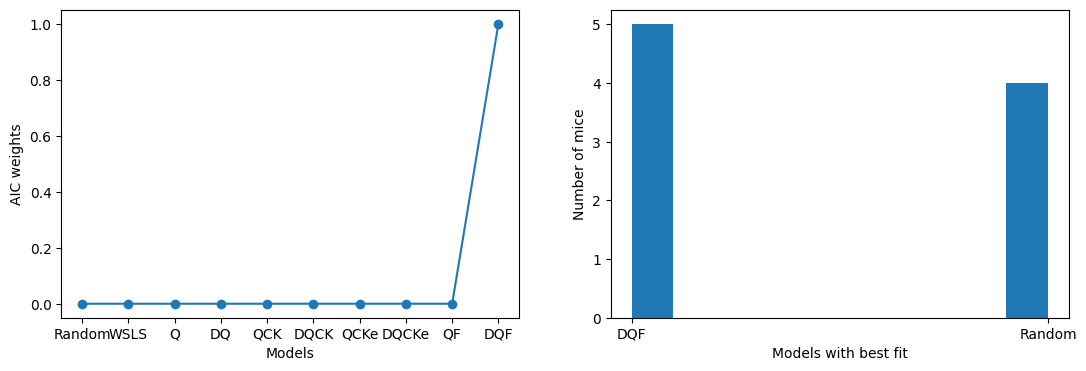

In [33]:
#All mice
best_model = plot_model_fit(results, save_fig = False, group_by=None, set_colors = None) #plot the fit of all models

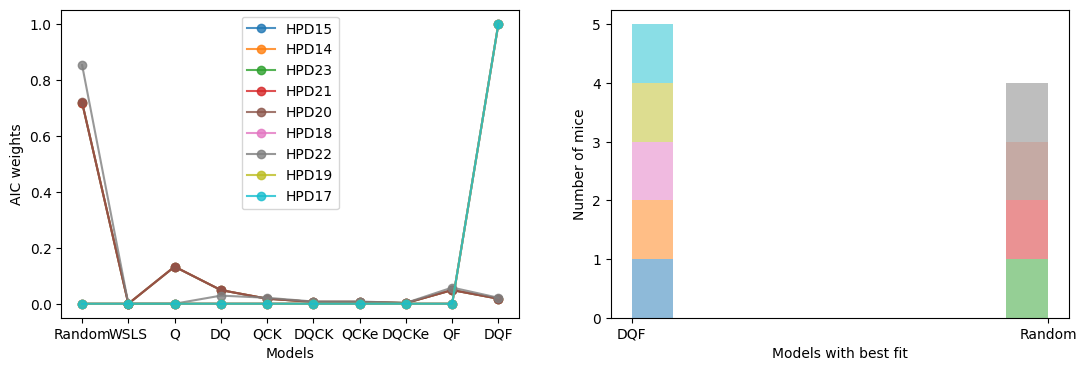

In [34]:
#Plotting inidividual mice
best_model = plot_model_fit(results, save_fig = True, group_by='ID', set_colors = ['blue', 'red', 'green', 'orange']) #plot the fit of all models

In [35]:
results

,ID,Session,Model,LogLike,Param,AIC,AIC weights
0,HPD14,1,Random,1223.024492,[0.5223542734029982],2450.048983,0.0
0,HPD14,1,WSLS,1224.106321,[0.99999],2452.212642,0.0
0,HPD14,1,Q,1224.791068,"[0.0, 0.0]",2455.582136,0.0
0,HPD14,1,DQ,1104.275876,"[1.0, 0.0, 3.6637598997743925]",2216.551752,0.0
0,HPD14,1,QCK,1224.791068,"[0.0, 0.0, 0.0, 0.0]",2459.582136,0.0
...,...,...,...,...,...,...,...
0,HPD23,1,DQCK,0.693151,"[1.0, 0.5354993135246991, 9.846559839692882, 1...",13.386301,0.006594
0,HPD23,1,QCKe,0.693148,"[1.0, 16.81151103734289, 1.0, 15.8036661510347...",13.386296,0.006594
0,HPD23,1,DQCKe,0.693148,"[1.0, 0.16788096115061837, 10.65151661270462, ...",15.386295,0.002426
0,HPD23,1,QF,0.693147,"[0.045765242639280994, 1.0, 48.380351944896795]",9.386294,0.048723


In [36]:
print('Model:', best_model)
parameters = {}
parameters[best_model] = getParameters(results, best_model, save=False)
parameters[best_model]

Model: DQF


,α+,α-,α_f,β
HPD14,1.000000,0.0,1.000000,4.107520
HPD15,1.000000,0.0,1.000000,4.096017
HPD17,1.000000,0.0,1.000000,4.662591
HPD18,1.000000,0.0,1.000000,5.071680
HPD19,1.000000,0.0,1.000000,4.266204
HPD20,1.000000,0.0,1.000000,16.403090
HPD21,1.000000,0.0,0.898842,18.950425
HPD22,0.184099,0.0,1.000000,24.904173
HPD23,1.000000,0.0,1.000000,17.676817


In [37]:
print('Model:', 'Random')
parameters['Random']= getParameters(results, 'Random', save=False)
parameters['Random']

Model: Random


,b
HPD14,0.522354
HPD15,0.638136
HPD17,0.636019
HPD18,0.605494
HPD19,0.506814
HPD20,0.999990
HPD21,0.999990
HPD22,0.999990
HPD23,0.999990


**Plot example trace**

<Figure size 640x480 with 0 Axes>

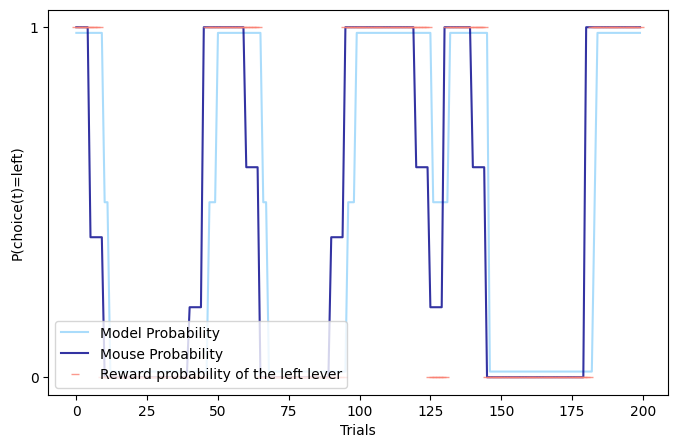

In [38]:
mouse = 'HPD14'

plot_ExampleBehaviour(data,mouse, 'DQF', parameters['DQF'], trials=[500,700],  size=[8,5], save = True)

# **5. Save Data**

In [39]:
#Save results to excel
with pd.ExcelWriter(path_to_save_data / 'RL_model_fit_results.xlsx') as writer:
    results.to_excel(writer, index=False)

#Save parameters to excel
with pd.ExcelWriter(path_to_save_data / 'RL_model_parameters.xlsx') as writer:
    for model in parameters.keys():
      parameters[model].to_excel(writer, index=True, sheet_name = model)